# Modelado de datos

El objetivo es crear un modelo de regresión lineal que pueda predecir el precio de un inmueble anunciado en la página de Airbnb. Antes de proceder, se ha hecho una selección de las columnas útiles y una limpieza de los datos. Además de eso, se explorará si todas las variables pueden ser útiles para este modelo.

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV
from pycaret.regression import *
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('airbnb_defv2.csv', index_col = 0)

## Elección de las variables

In [4]:
df.head().transpose()

,1,2,3,4,5
ID,15141125,9470166,17444981,3284565,499911
Host.Since,2009-05-17,2009-06-02,2009-06-02,2009-06-02,2009-08-14
Neighbourhood.Cleansed,EMBAJADORES,EMBAJADORES,EMBAJADORES,EMBAJADORES,EMBAJADORES
Neighbourhood.Group.Cleansed,CENTRO,CENTRO,CENTRO,CENTRO,CENTRO
City,MADRID,MADRID,MADRID,MADRID,MADRID
Zipcode,28005.0,28012.0,28012.0,28012.0,28012.0
Country,Spain,Spain,Spain,Spain,Spain
Latitude,4.040.745.268.477.800,4.040.831.556.101.920,40.413.722.014.584.200,40.411.263.372.718.000,4.041.255.625.665.070
Longitude,-37.079.954.754.432.600,-3.705.006.385.704.200,-37.068.231.186.536.700,-36.973.054.373.712.800,-3.701.155.364.799.420
Property.Type,LOFT,APARTMENT,APARTMENT,APARTMENT,APARTMENT


In [6]:
df.dtypes

ID                                  int64
Host.Since                         object
Neighbourhood.Cleansed             object
Neighbourhood.Group.Cleansed       object
City                               object
Zipcode                           float64
Country                            object
Latitude                           object
Longitude                          object
Property.Type                      object
Room.Type                          object
Accommodates                        int64
Bed.Type                           object
Security.Deposit                    int64
Cleaning.Fee                        int64
Number.of.Reviews                   int64
Review.Scores.Rating                int64
Host.Response.Rate                float64
Bathrooms                         float64
Bedrooms                            int64
Beds                                int64
Price                               int64
Security.Deposit_bool               int64
Cleaning.fee_bool                 

In [7]:
df.shape

(12373, 25)

In [6]:
df.City.nunique()

1

El dataset dispone de 25 variables, de las cuales 10 son variables cualitativas y 15 son variables numéricas. 
Algunas de estas variables se pueden eliminar ya que no van a aportar más información. No se incluirán:
* ID: es el identificador de la fila, no da información al algoritmo
* Zipcode: el código postal no se puede tomar como número ya que el algoritmo lo interpretaría como un orden, y para usarlo como una variable categórica ya disponemos de los barrios 
* Latitude y Longitude: lo mismo que arriba, ya se dispone de los barrios, y además el algoritmo no es capaz de interpretar que estas dos variables van de la mano, pues aquí están separadas en dos columnas diferentes. 
* City: solo hay un valor posible, Madrid
* Country: solo hay un valor posible, España

Como se puede observar, hay variables numéricas y variables categóricas. Estas últimas han de transformarse en dummies para poder utilizarlas en el algoritmo. 

In [3]:
df = df.drop(['ID'], axis = 1)

df = df.drop(['Zipcode'], axis = 1)

df = df.drop(['Latitude'], axis = 1)

df = df.drop(['Longitude'], axis = 1)

df = df.drop(['City'], axis = 1)

df = df.drop(['Country'], axis = 1)

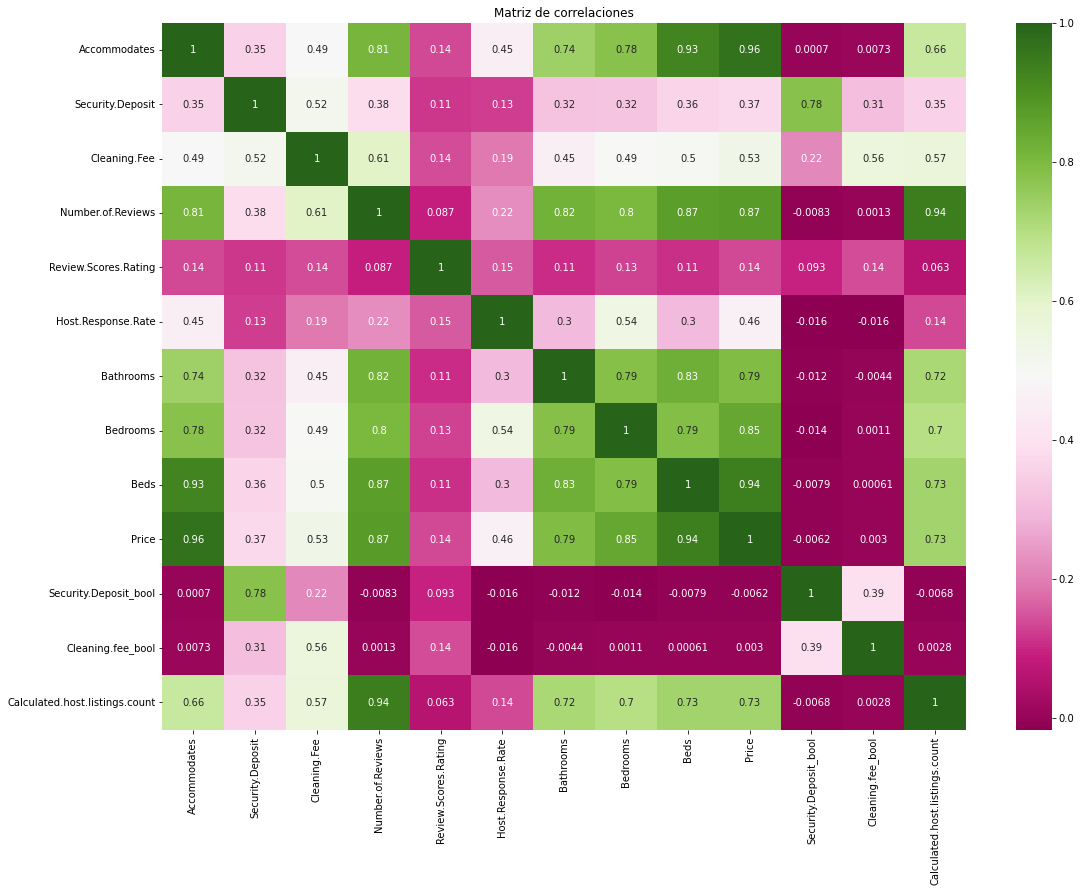

In [38]:
plt.figure(figsize = (18, 13))
sns.heatmap(df.corr(), annot = True, cmap = "PiYG").set(
    title = "Matriz de correlaciones")
plt.show()

El gráfico superior representa una matriz de correlaciones entre las variables numéricas del dataset. Se puede ver que la mayoría están correlacionadas con el precio, excepto Security.Deposit_bool y Cleaning.fee_bool, que son columnas calculadas en base a si el listing tiene depósito de seguridad o gastos de limpieza. Siendo valores tan cercanos a 0, se pueden eliminar del modelo. 

En cuanto a las demás variables, es llamativo ver la alta correlación entre las variables. Se cumplen las hipótesis planteadas; el precio es mayor cuantas más personas acomoda, por lo tanto también afectan el número de camas, habitaciones y baños. Es coherente, puesto que son inmuebles más grandes. También es interesante ver que a mayor número de propiedades tiene el anfitrión anunciándose en Airbnb, mayor será el precio de un inmueble suyo.

In [4]:
df = df.drop(['Security.Deposit_bool'], axis = 1)

df = df.drop(['Cleaning.fee_bool'], axis = 1)

In [5]:
#get neighbourhood group cleansed dummies
dummynbg = pd.get_dummies(df['Neighbourhood.Group.Cleansed'])
#get property type dummies
dummypt = pd.get_dummies(df['Property.Type'])
#get room type dummies
dummyrt = pd.get_dummies(df['Room.Type'])
#get bed type dummies
dummybt = pd.get_dummies(df['Bed.Type'])


In [6]:
dummynbg.head()

,ARGANZUELA,BARAJAS,CARABANCHEL,CENTRO,CHAMARTIN,CHAMBERI,CIUDAD LINEAL,FUENCARRAL - EL PARDO,HORTALEZA,LATINA,...,MORATALAZ,PUENTE DE VALLECAS,RETIRO,SALAMANCA,SAN BLAS - CANILLEJAS,TETUAN,USERA,VICALVARO,VILLA DE VALLECAS,VILLAVERDE
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Se han hecho variables dummies de las columnas de neighbourhood group, property type, room type y bed type para poder introducirlas en el algoritmo de regresión lineal. 

In [6]:
#adding dummies to the main dataframe
df = pd.concat([df, dummynbg, dummypt, dummyrt, dummybt], axis = 1)

In [7]:
#dropping non dummies from the main dataframe
df = df.drop(['Neighbourhood.Group.Cleansed'], axis = 1)

df = df.drop(['Property.Type'], axis = 1)

df = df.drop(['Room.Type'], axis = 1)

df = df.drop(['Bed.Type'], axis = 1)

In [11]:
df.head()

,Country,Accommodates,Security.Deposit,Cleaning.Fee,Number.of.Reviews,Review.Scores.Rating,Host.Response.Rate,Bathrooms,Bedrooms,Beds,...,TOWNHOUSE,VILLA,ENTIRE HOME/APT,PRIVATE ROOM,SHARED ROOM,AIRBED,COUCH,FUTON,PULL-OUT SOFA,REAL BED
1,Spain,1,0,0,0,20,0.0,0.0,0,1,...,0,0,1,0,0,0,0,0,0,1
2,Spain,1,0,4,0,20,0.0,0.0,0,1,...,0,0,1,0,0,0,0,0,0,1
3,Spain,1,0,4,0,20,0.0,0.0,0,1,...,0,0,1,0,0,0,0,0,0,1
4,Spain,1,66,5,0,20,0.0,0.0,0,1,...,0,0,1,0,0,0,0,0,0,1
5,Spain,1,70,5,0,20,0.0,0.0,0,1,...,0,0,1,0,0,0,0,0,0,1


## Preprocesamiento

Para comprobar el funcionamiento del modelo hay que dividir el dataset en dos. Una parte con la que se entrenará el modelo y otra con datos que no ha visto aún para comprobar que funciona bien y que no hay overfitting.

In [8]:
features = df.drop("Price", axis = 1)

#divide into train and test
X_train, X_test, y_train, y_test = train_test_split(features, df.Price, test_size = 0.3, random_state = 8)

In [9]:
lm = linear_model.LinearRegression()

#train the model
lm.fit(X_train, y_train)

#make prediction using the test subset
y_pred = lm.predict(X_test) 

In [10]:
print("R squared:", round(lm.score(features, df.Price), 3))

R squared: 0.967


El R² obtenido da un valor muy cercano a 1. Cuanto más cercano a este valor, más se ajusta. Sin embargo, no tiene en cuenta el overfitting. Para ello hay otras métricas que se pueden usar en conjunto con esta, como el error cuadrático promedio (MSE).

In [11]:
from sklearn.metrics import mean_squared_error
msel = mean_squared_error(y_test, y_pred)
print("Mean squared error:", round(msel, 3))

Mean squared error: 33.821


El MSE da un valor que indica cuánto se ajusta el modelo; cuánto se desvían los resultados obtenidos de los números reales. Al dar un valor absoluto, por sí solo no es muy útil, pero puede usarse para comparar con otros modelos y seleccionar el mejor. Este sería el MSE con valor más cercano a 0.

Para comprobar si puede mejorar el modelo, se cambiarán los diferentes parámetros que admite la regresión linear. Se usará GridSearch.

In [12]:
linear_model.LinearRegression().get_params().keys()

dict_keys(['copy_X', 'fit_intercept', 'n_jobs', 'normalize', 'positive'])

In [13]:
#cross validator
cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 8)

In [26]:
#dictionary with parameters 
params = dict()

params["copy_X"] = [True, False]
params["fit_intercept"] = [True, False]
params["normalize"] = [True, False]
params["positive"] = [True, False]

search = GridSearchCV(linear_model.LinearRegression(), params, scoring = "neg_mean_squared_error", cv =  cv)

In [27]:
search.fit(X_train, y_train)

C:\Users\Nuria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
C:\Users\Nuria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be remo

GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=10, random_state=8),
             estimator=LinearRegression(),
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'normalize': [True, False],
                         'positive': [True, False]},
             scoring='neg_mean_squared_error')

In [28]:
y_pred2 = search.predict(X_test) 

In [29]:
print("R squared:", round(search.score(features, df.Price), 3))

R squared: -34.498


In [31]:
mse2 = mean_squared_error(y_test, y_pred2)
print("Mean squared error:", round(mse2, 3))

Mean squared error: 33.824


El objetivo era afinar el modelo para conseguir un mejor resultado, concretamente un mejor MSE, porque el R² ya tenía un valor muy alto y se ha de evitar recompensar el overfitting. El objetivo de este modelo es que con los parámetros que se le da pueda predecir futuros precios. Por esa razón hay que evitar que el modelo se ajuste demasiado bien a estos datos. Sin embargo, el MSE no mejora, y el R² empeora mucho, se vuelve negativo. Un R² compara el modelo con una línea horizontal, y si este predice peor que esa línea, el resultado es negativo. 

## Pruebas con otros modelos

Viendo la gran correlación entre variables, era de esperar de primeras unos resultados tan altos en cuanto ajuste del modelo. La regresión lineal simple es también un algoritmo bastante sencillo y tiene poco margen de mejora, y más con estos resultados. Sin embargo, existen otros algoritmos que tal vez puedan crear un mejor modelo. Para compararlos, se usará Pycaret, que divide el dataset en test y train, normaliza y transforma los datos para mejorar los modelos y compara los diferentes algoritmos de regresión según las posibles métricas.

In [8]:
reg8 = setup(data = df, target = "Price", session_id = 8, normalize = True, transformation = True, n_jobs = None)

,Description,Value
0,Session id,8
1,Target,Price
2,Target type,Regression
3,Original data shape,"(12373, 62)"
4,Transformed data shape,"(12373, 62)"
5,Transformed train set shape,"(8661, 62)"
6,Transformed test set shape,"(3712, 62)"
7,Numeric features,61
8,Preprocess,1
9,Imputation type,simple


In [48]:
comparison = compare_models(exclude = ['lr'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
dt,Decision Tree Regressor,0.2329,0.3661,0.6039,0.9997,0.0161,0.0058,0.1590
rf,Random Forest Regressor,0.2324,0.2915,0.5389,0.9997,0.0144,0.0058,1.9920
lightgbm,Light Gradient Boosting Machine,0.3349,0.3299,0.5738,0.9997,0.0155,0.0086,0.4130
et,Extra Trees Regressor,0.2605,0.4108,0.6395,0.9996,0.0167,0.0065,2.7040
gbr,Gradient Boosting Regressor,0.4597,0.5303,0.7280,0.9995,0.0198,0.0120,1.1820
ada,AdaBoost Regressor,2.2241,7.2444,2.6751,0.9932,0.0770,0.0536,0.7280
ridge,Ridge Regression,3.3543,19.8091,4.4471,0.9814,0.1755,0.0791,0.2810
br,Bayesian Ridge,3.3534,19.8095,4.4471,0.9814,0.1750,0.0791,0.1830
omp,Orthogonal Matching Pursuit,3.3609,19.8690,4.4538,0.9813,0.1712,0.0794,0.1840
huber,Huber Regressor,3.0085,25.1560,5.0035,0.9764,0.0804,0.0674,0.4860


Según la tabla superior, Random Forest da los mejores resultados. No solo obtiene un R² superior al modelo de regresión lineal, sino que obtiene un MSE menor a todos los demás modelos. Además, sobresale en el resto de las métricas obtenidas.

Los resultados de esta tabla se obtienen tras una validación cruzada k-fold 10 veces. Es decir, se calcula 10 veces y devuelve la media de todos los resultados. En la tabla inferior se puede ver con detalle las métricas obtenidas en cada una de las 10 iteraciones.

In [9]:
#create random forest model
rf = create_model("rf")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2283,0.2926,0.5409,0.9997,0.0142,0.0056
1,0.2446,0.3156,0.5618,0.9997,0.0153,0.0063
2,0.2205,0.2633,0.5131,0.9997,0.0138,0.0055
3,0.2376,0.2786,0.5278,0.9997,0.0137,0.0059
4,0.2695,0.3931,0.6270,0.9996,0.0161,0.0066
5,0.2361,0.2766,0.5259,0.9997,0.0139,0.0058
6,0.2343,0.2986,0.5465,0.9997,0.0147,0.0059
7,0.2233,0.2605,0.5104,0.9997,0.0139,0.0057
8,0.2240,0.2779,0.5272,0.9997,0.0143,0.0058


### Random Forest

Así como la regresión lineal permitía hacer un Gridsearch para afinar los hiperparámetros, se puede hacer lo mismo con Random Forest.

In [10]:
#tune random forest hiperparams
tuned_rf = tune_model(rf)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.2671,21.8783,4.6774,0.9797,0.1389,0.0951
1,3.0477,19.2889,4.3919,0.9809,0.1330,0.0908
2,2.9938,18.3430,4.2829,0.9817,0.1305,0.0891
3,3.0196,19.0903,4.3692,0.9828,0.1216,0.0831
4,3.2387,20.7559,4.5559,0.9803,0.1452,0.0998
5,2.9995,19.3602,4.4000,0.9819,0.1218,0.0836
6,3.0797,19.1188,4.3725,0.9812,0.1334,0.0907
7,3.4852,25.3993,5.0398,0.9751,0.1453,0.1013
8,3.5127,24.9430,4.9943,0.9773,0.1472,0.1052


Con el modelo afinado, se puede ahora observar qué variables ha dado más importancia el modelo. Cabe aclarar que no tiene que ver con la correlación, es tan solo los parámetros que ha tenido en cuenta el algoritmo a la hora de calcular, al azar, como su nombre indica. Se puede observar que el número de reseñas de un inmueble tiene la mayor importancia con diferencia, seguido por la tasa de respuesta del anfitrión y el número de anuncios del anfitrión en la página web. 

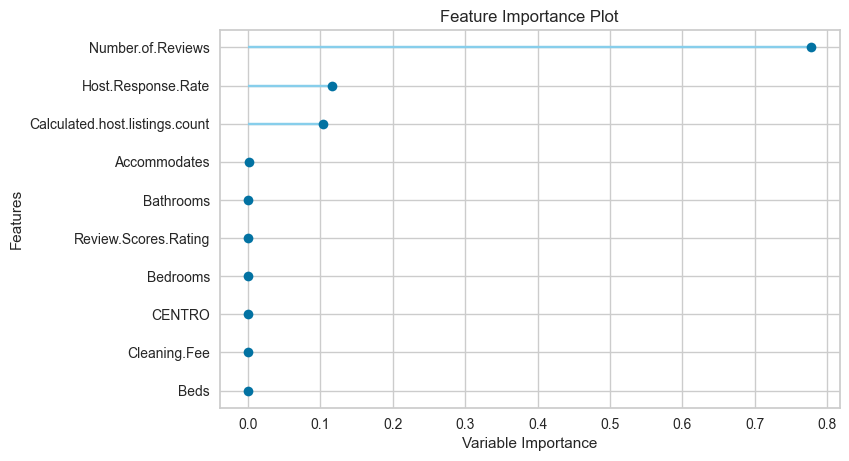

In [52]:
plot_model(tuned_rf, plot = 'feature')

In [12]:
evaluate_model(tuned_rf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Una vez hecho esto, se entrena el modelo con todos los datos disponibles, de manera que se ajuste mejor a nuevos datos en el futuro, y se obtienen métricas similares, descartando el overfitting de nuevo.

In [13]:
final_rf = finalize_model(tuned_rf)

In [14]:
predict_model(final_rf)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.2175,0.2924,0.5408,0.9997,0.0166,0.0057


,Accommodates,Security.Deposit,Cleaning.Fee,Number.of.Reviews,Review.Scores.Rating,Host.Response.Rate,Bathrooms,Bedrooms,Beds,Calculated.host.listings.count,...,ENTIRE HOME/APT,PRIVATE ROOM,SHARED ROOM,AIRBED,COUCH,FUTON,PULL-OUT SOFA,REAL BED,Price,prediction_label
8661,4,0,0,23,97,100.000000,1.0,1,2,4,...,1,0,0,0,0,0,0,1,75,75.000000
8662,3,180,30,10,0,100.000000,1.0,1,2,2,...,1,0,0,0,0,0,0,1,59,59.010000
8663,2,0,0,1,0,94.823463,1.0,1,1,1,...,0,0,1,0,0,0,0,1,35,33.892559
8664,2,0,15,1,0,94.823463,1.0,1,1,1,...,0,1,0,0,0,0,0,1,30,30.362358
8665,2,100,12,0,86,94.823463,1.0,1,1,1,...,1,0,0,0,0,0,0,1,25,25.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12368,1,0,0,0,82,90.000000,1.0,1,1,1,...,1,0,0,0,0,0,0,1,23,23.000000
12369,2,0,15,0,0,94.823463,1.0,1,1,1,...,0,1,0,0,0,0,0,1,29,28.993854
12370,2,0,20,4,93,100.000000,1.0,1,1,1,...,0,1,0,0,0,0,0,1,47,47.000000
12371,5,0,60,73,100,100.000000,2.0,2,3,28,...,0,1,0,0,0,0,0,1,110,110.000000


Por último, se guarda el modelo para poder consultarlo más adelante en un archivo pickle, con extensión .pkl.

In [15]:
save_model(final_rf, "Random Forest Price Airbnb 20230210")

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=C:\Users\Nuria\AppData\Local\Temp\joblib),
          steps=[('clean_column_names',
                  TransformerWrapper(transformer=CleanColumnNames())),
                 ('numerical_imputer',
                  TransformerWrapper(include=['Accommodates', 'Security.Deposit',
                                              'Cleaning.Fee',
                                              'Number.of.Reviews',
                                              'Review.Scores.Rating',
                                              'Host.Response.Rate', 'Bathrooms',
                                              'Bedrooms', 'Beds',
                                              'Ca...
                                              'VILLA DE VALLECAS', ...],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer

In [17]:
import session_info 
session_info.show()